In [1]:
import itertools

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.optim as optim
import torch.nn.functional as F
import torch.nn.init as init
from torch import nn
from torch import distributions
from torch.distributions import MultivariateNormal

from nflib.flows import MAF, NormalizingFlowModel

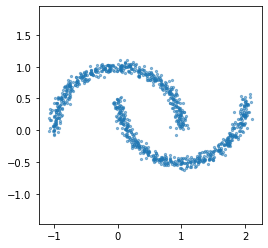

In [2]:
from sklearn import datasets

class TwoHalfMoons:
    def sample(self, n):
        moons = datasets.make_moons(n_samples=n, noise=0.05)[0].astype(np.float32)
        return torch.from_numpy(moons)

d = TwoHalfMoons()

x = d.sample(1024)
plt.figure(figsize=(4,4))
plt.scatter(x[:,0], x[:,1], s=5, alpha=0.5)
plt.axis('equal');

In [3]:
# construct a model
prior = MultivariateNormal(torch.zeros(2), torch.eye(2))

# MAF (with MADE net, so we get very fast density estimation)
flows = [MAF(dim=2, parity=1) for i in range(8)]
#flows = [MAF(dim=2, parity=i%2) for i in range(8)]

# construct the model
model = NormalizingFlowModel(prior, flows)

In [4]:
# optimizer
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5) # todo tune WD
print("number of params: ", sum(p.numel() for p in model.parameters()))

number of params:  10976


In [5]:
model.train()
for k in range(10000):
    x = d.sample(256)
    
    zs, prior_logprob, log_det = model(x)
    logprob = prior_logprob + log_det
    loss = -torch.sum(logprob) # NLL

    model.zero_grad()
    loss.backward()
    optimizer.step()

    if k % 100 == 0:
        print(loss.item())


696.7926635742188
551.757080078125
462.50823974609375
443.58343505859375
429.6953125
416.6450500488281
411.082275390625
403.013671875
393.8336181640625
373.5193786621094
345.7045593261719
309.2414855957031
291.4549560546875
282.19561767578125
278.7491149902344
254.8526153564453
306.73028564453125
239.19717407226562
231.24661254882812
235.18478393554688
225.90985107421875
270.2638244628906
241.77572631835938
229.71707153320312
246.35812377929688
226.7613983154297
222.35435485839844
215.0425567626953
219.63380432128906
210.2574005126953
201.76722717285156
204.40890502929688
222.4284210205078
204.5006103515625
203.65679931640625
198.095458984375
190.1781768798828
201.54444885253906
186.7672119140625
190.71168518066406
197.53604125976562
208.68038940429688
185.62303161621094
229.2344207763672
183.26083374023438
195.11965942382812
190.20787048339844
194.93161010742188
186.51316833496094
184.7724609375
177.2708282470703
185.08677673339844
183.42835998535156
165.32498168945312
167.58833312988

Text(0.5, 1.0, 'x -> z')

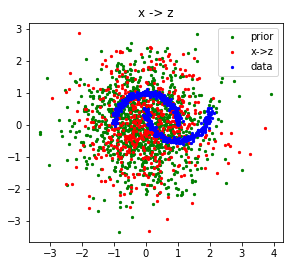

In [6]:
model.eval()

batch_size = 512
x = d.sample(batch_size)
z, prior_logprob, log_det = model(x)

x = x.detach().numpy()
z = z.detach().numpy()
p = model.prior.sample([batch_size, 2]).squeeze()
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.scatter(p[:,0], p[:,1], c='g', s=5, label='prior')
plt.scatter(z[:,0], z[:,1], c='r', s=5, label='x->z')
plt.scatter(x[:,0], x[:,1], c='b', s=5, label='data')
plt.legend()

plt.axis('scaled')
plt.title('x -> z')

Text(0.5, 1.0, 'z -> x')

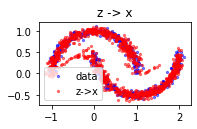

In [7]:
z = model.sample(128*8).detach().numpy()

plt.subplot(122)
plt.scatter(x[:,0], x[:,1], c='b', s=5, alpha=0.5)
plt.scatter(z[:,0], z[:,1], c='r', s=5, alpha=0.5)
plt.legend(['data', 'z->x'])
plt.axis('scaled')
plt.title('z -> x')